# Поиск оптимального региона.

Компания «ГлавРосГосНефть» поставила задачу решить, где бурить новую скважину. 

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Также необходимо проанализировать возможную прибыль и риски техникой *Bootstrap.*

Описание данных:

     id — уникальный идентификатор скважины;
     f0, f1, f2 — три признака точек;
     product — объём запасов в скважине (тыс. баррелей).

## Оглавление:
 - <a href=#1> 1 Подготовка данных.</a>
   - <a href=#1.1>1.1 Изучение данных.</a>
   - <a href=#1.2>1.2 Подготовка данных для модели.</a>
 - <a href=#2> 2 Обучение и проверка модели.</a>
 - <a href=#3> 3 Подготовка к расчёту прибыли.</a>
 - <a href=#4> 4 Расчёт прибыли и рисков.</a>

# 1. Подготовка данных. <a id="1" />
## 1.1 Изучение данных. <a id="1.1" />
Загрузим и изучим имеющиеся у нас данные. 

In [1]:
from math import ceil

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


rand = np.random.RandomState(42)

In [2]:
data_0 = pd.read_csv("/datasets/geo_data_0.csv")
data_1 = pd.read_csv("/datasets/geo_data_1.csv")
data_2 = pd.read_csv("/datasets/geo_data_2.csv")

display(data_0.head())
display(data_1.head())
display(data_2.head())
print(data_0.info())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


Мы видим, что регионы имеют разные масштабы признаков. Посмотри, как распределены признаки относительно друг-друга, для этого введем дополнительный признак `region`, для исследования будет достаточно части выборки.

Для единства размерности масштабируем получившиеся выборки.

In [3]:
def scaller(df):
    min_max_scaler = MinMaxScaler()
    return min_max_scaler.fit_transform(df)
    

In [4]:
data_scale_0 = data_0.sample(1000).copy()
data_scale_1 = data_1.sample(1000).copy()
data_scale_2 = data_2.sample(1000).copy()

data_scale_0['region'] = 0
data_scale_1['region'] = 1
data_scale_2['region'] = 2

data_scale_0[['f0','f1','f2']] = scaller(data_scale_0[['f0','f1','f2']])
data_scale_1[['f0','f1','f2']] = scaller(data_scale_1[['f0','f1','f2']])
data_scale_2[['f0','f1','f2']] = scaller(data_scale_2[['f0','f1','f2']])

data_scale_full = pd.concat([data_scale_0, 
                             data_scale_1,
                             data_scale_2], ignore_index=True)

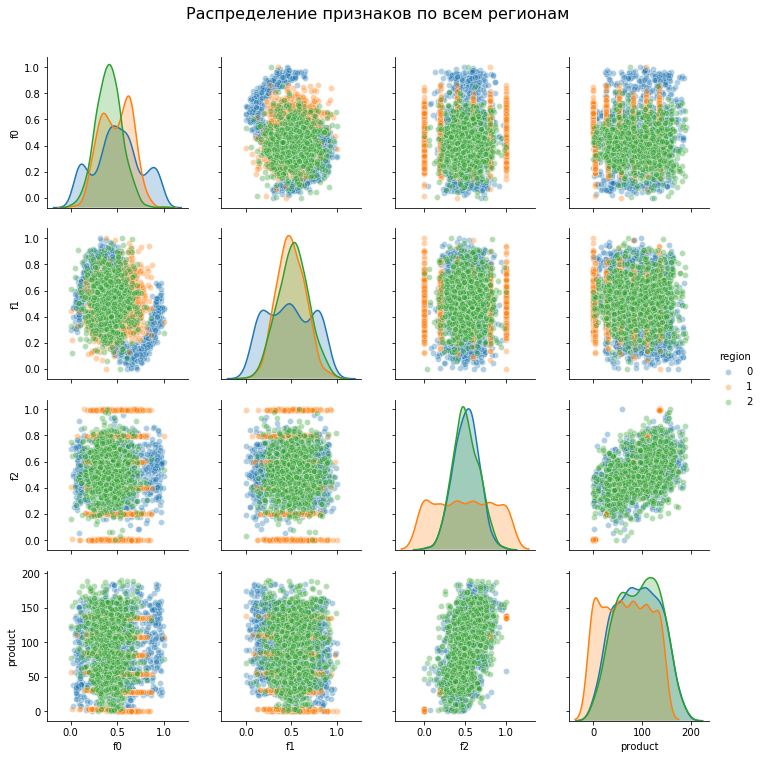

In [5]:
sns.pairplot(data_scale_full,
             x_vars=['f0','f1','f2','product'],
             y_vars = ['f0','f1','f2','product'],
             plot_kws={'alpha': 0.35},
             hue='region').fig.suptitle('Распределение признаков по всем регионам', y=1.05, fontsize=16);


Мы видим, что распределение признаков по регионам сильно отличаются, следовательно мы вынуждены рассматривать все 3 региона, как отдельные выборки и для каждой построить свою модель предсказания.


In [6]:
def make_heatmap(ax_x, df, title):
    sns.heatmap(df.corr(), 
            annot=True, ax=ax_x).set_title(title);

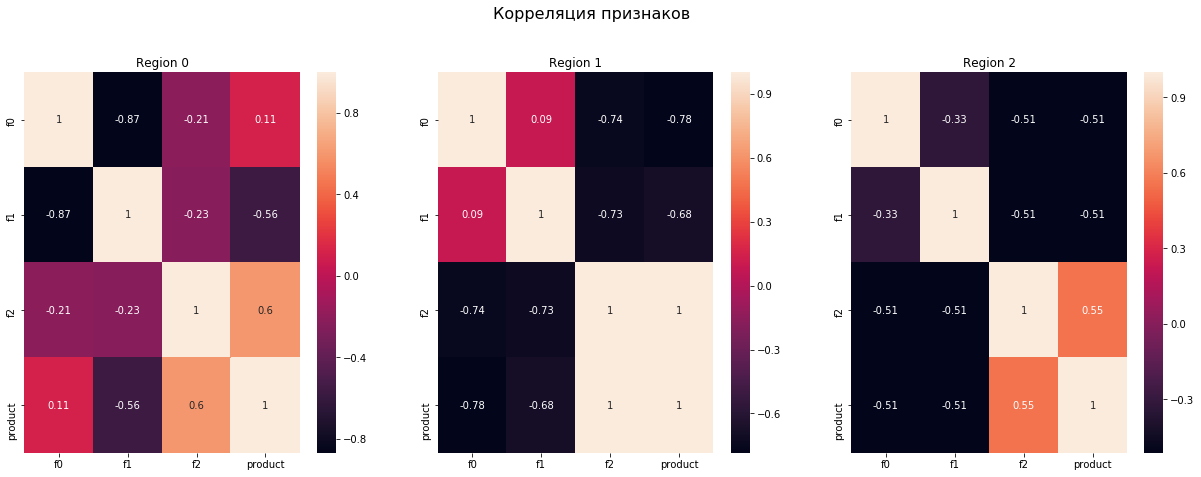

In [7]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(21,7));
fig.suptitle('Корреляция признаков', y=1.01, fontsize=16)
make_heatmap(ax0, data_0.corr(method='spearman'), 'Region 0')
make_heatmap(ax1, data_1.corr(method='spearman'), 'Region 1')
make_heatmap(ax2, data_2.corr(method='spearman'), 'Region 2')

Переменные очень сильно коррелируют между собой.

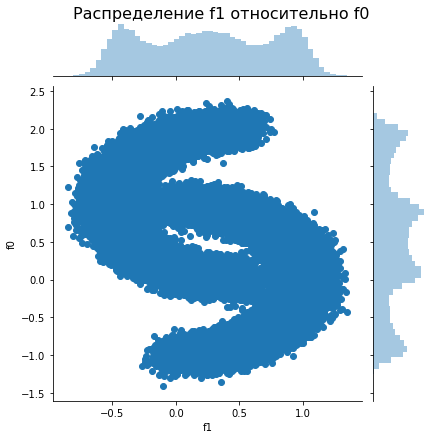

In [8]:
sns.jointplot(data_0['f1'], data_0['f0']).fig.suptitle('Распределение f1 относительно f0', y=1.01, fontsize=16);


А распределение некоторых признаков могут указывать на то, что скважины можно разделить на несколько групп, по которым можно построить более точную модель.
Но как это сделать я пока не понимаю.



## 1.2 Подготовка данных для модели. <a id="1.2" />

Разобьем выборки на тренировочные и тестовые. Также сохраним признак id в отдельной переменной.

In [9]:
name_0 = data_0['id']
name_1 = data_1['id']
name_2 = data_2['id']

data_0 = data_0.drop('id', axis=1)
data_1 = data_1.drop('id', axis=1)
data_2 = data_2.drop('id', axis=1)


X0_train, X0_test, y0_train, y0_test = train_test_split(data_0.drop(['product'], axis=1),
                                                        data_0['product'],
                                                        test_size=0.25, random_state=rand)
X1_train, X1_test, y1_train, y1_test = train_test_split(data_1.drop(['product'], axis=1),
                                                        data_1['product'],
                                                        test_size=0.25, random_state=rand)
X2_train, X2_test, y2_train, y2_test = train_test_split(data_2.drop(['product'], axis=1),
                                                        data_2['product'],
                                                        test_size=0.25, random_state=rand)
display(X0_train.head(),  y0_test.head())

,f0,f1,f2
98980,1.611925,-0.151874,1.221668
69824,-0.896203,0.369086,-4.537914
9928,0.217569,0.974254,7.369521
75599,0.882945,0.669249,3.114527
95621,-0.941661,0.634162,2.873607


75721    122.073350
80184     48.738540
19864    131.338088
76699     88.327757
92991     36.959266
Name: product, dtype: float64

Теперь, не боясь испортить независимость тестовых данных, мы можем подготовить тренировочные данные для нашей модели.

Избавимся от выбросов.

In [10]:
def min_max_cut(df):
    df_copy = df.copy()
    columns = list(df_copy.select_dtypes(np.number).columns)
    for col in columns:
        filtr = (df_copy[col] > df_copy[col].quantile(0.01)) & (df_copy[col] < df_copy[col].quantile(0.99))
        df_copy[col] = df_copy[col][filtr]
    return df_copy.dropna()
    

In [11]:
X0_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75000 entries, 98980 to 15795
Data columns (total 3 columns):
f0    75000 non-null float64
f1    75000 non-null float64
f2    75000 non-null float64
dtypes: float64(3)
memory usage: 2.3 MB


In [12]:
X0_filtr_train = min_max_cut(X0_train)
X1_filtr_train = min_max_cut(X1_train)
X2_filtr_train = min_max_cut(X2_train)

y0_filtr_train = y0_train[X0_filtr_train.index]
y1_filtr_train = y1_train[X1_filtr_train.index]
y2_filtr_train = y2_train[X2_filtr_train.index]

In [13]:
print(X0_filtr_train.head())
X0_filtr_train.info()

             f0        f1        f2
98980  1.611925 -0.151874  1.221668
69824 -0.896203  0.369086 -4.537914
9928   0.217569  0.974254  7.369521
75599  0.882945  0.669249  3.114527
95621 -0.941661  0.634162  2.873607
<class 'pandas.core.frame.DataFrame'>
Int64Index: 70557 entries, 98980 to 15795
Data columns (total 3 columns):
f0    70557 non-null float64
f1    70557 non-null float64
f2    70557 non-null float64
dtypes: float64(3)
memory usage: 2.2 MB


Для построения моделей произведем стандартизацию параметров.

In [14]:
def standartization(df):
    x_scaler =  StandardScaler().fit(df)
    return x_scaler, x_scaler.transform(df)
    

In [15]:
x0_scaler, X0_filtr_train  = standartization(X0_filtr_train)
x1_scaler, X1_filtr_train  = standartization(X1_filtr_train)
x2_scaler, X2_filtr_train  = standartization(X2_filtr_train)

## Выводы по разделу.
Во всех 3-х регионах распределение параметров очень сильно отличаюстя друг от друга, поэтому нам необходимо рассматривать их отдельно, при этом в регионе 1 были найдены закономерности, которые могут указывать на то, что скважины можно кластеризировать на две различающиеся группы.

Мы подготовили данные для дальнейшего исследования. Параметры взятые для обучения модели были очищены от шума и нормализованы.

# 2. Обучение и проверка модели <a id="2" />
Построим модель линейной регрессии, которая будет предсказывать нам запас сырья.
Напишем функцию, которая будет обучать модель и записывать результаты исследования в отдельные переменные. Так как мы уже отобрали тестовую выборку, то мы можем использовать эти данные для проверки работы нашей модели.

In [16]:
X0_test = x0_scaler.transform(X0_test)
X1_test = x1_scaler.transform(X1_test)
X2_test = x2_scaler.transform(X2_test)

In [17]:
def make_model_and_pred(X_train, y_train, X_val, y_val, reg="reg"):
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    
    
    predictions = model.predict(X_val)
    
    results = pd.DataFrame({'target':y_val, 'predict':predictions})
    rmse = mean_squared_error(y_val, predictions)**0.5
    
    print("Значения для", reg)
    print("Истинный средний запас сырья: {:.2f}".format(y_val.mean()))
    print("Предсказанный средний запас сырья: {:.2f}".format(predictions.mean()))
    print("Корень из среднеквадратичного отклонения(RMSE): {:.2f} \n".format(rmse))
    
    return  (model, results)

In [18]:
model_0, results0 = make_model_and_pred(X0_filtr_train, y0_filtr_train, X0_test, y0_test, 'Region 1')
model_1, results1 = make_model_and_pred(X1_filtr_train, y1_filtr_train, X1_test, y1_test, 'Region 2')
model_2, results2 = make_model_and_pred(X2_filtr_train, y2_filtr_train, X2_test, y2_test, 'Region 3')

Значения для Region 1
Истинный средний запас сырья: 92.33
Предсказанный средний запас сырья: 92.38
Корень из среднеквадратичного отклонения(RMSE): 37.76 

Значения для Region 2
Истинный средний запас сырья: 68.60
Предсказанный средний запас сырья: 68.59
Корень из среднеквадратичного отклонения(RMSE): 0.89 

Значения для Region 3
Истинный средний запас сырья: 95.04
Предсказанный средний запас сырья: 94.50
Корень из среднеквадратичного отклонения(RMSE): 40.25 



Нарисуем график для региона 1 и 2, отобразим на них реальные и предсказанные значения целевого признака. Чтобы не зашумлять картинку выберем по 100 точек из выборки.

In [19]:
def plot_tar_pred(target, predict, n, name):
    line_dat = results1.sample(n)
    plt.figure(figsize=(12,6))
    plt.plot(range(n), target, label='target')
    plt.plot(range(n), predict, label='predict')
    plt.legend()
    plt.title(name)
    plt.show()

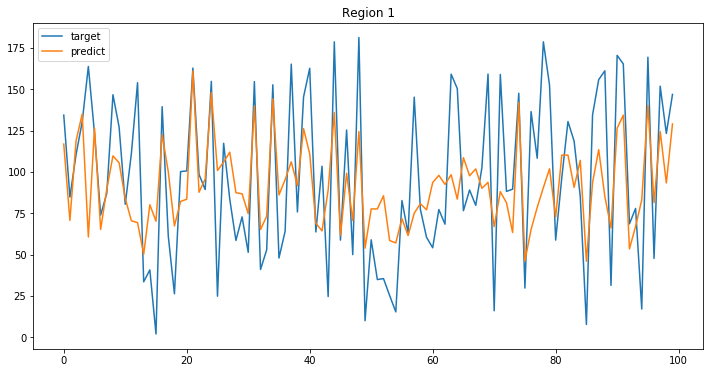

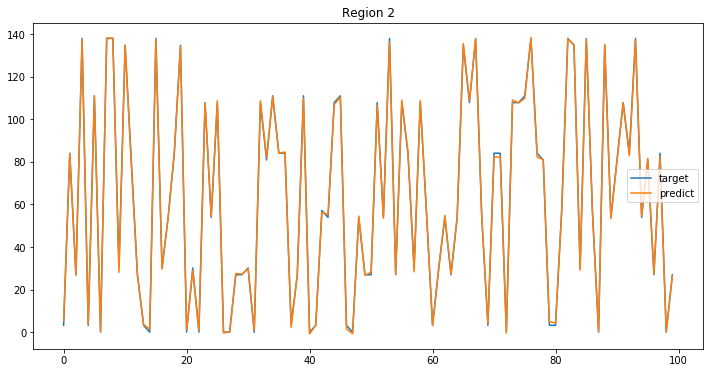

In [20]:
n = 100

line_dat = results0.sample(n)
plot_tar_pred(line_dat['target'], line_dat['predict'], n, 'Region 1')

line_dat = results1.sample(n)
plot_tar_pred(line_dat['target'], line_dat['predict'], n, 'Region 2')


## Выводы по разделу.
Мы построили модель предсказывающую объем запасов в новых скважинах. Для региона 1 и 3 средние значения предсказанного объема близки к истинным, но значение корня среднеквадратичного отклонения очень большое, что означает, что для конкретной скважины мы можем ошибаться на 50% её объема. Это подтверждается и на графиках.

Для региона 2 мы наблюдаем другую картину, там модель успешно справилась с предсказанием и очень точно определяет как общие запасы, так и запасы в конкретной скважине.

# 3. Подготовка к расчёту прибыли <a id="3" />
Для расчета прибыли нам потребуются следующие значения:
- Стоимость разработки одной скважины;
- Доход с единицы продукта;
- Предсказанные значения product для каждого региона.

Для разработки в регионе выбирают 200 самых перспективных скважин, всего на разработку выделяют 10 млрд рублей.

In [21]:
budget = 10000000000
product_income = 450000

Рассчитаем, сколько сырья нам необходимо для безубыточной разработки скажины.

In [22]:
profit_line = ceil(budget/product_income/200)

In [23]:
print("Бюджет разработки региона: {:.2f}".format(budget))
print("Доход с еденицы продукта: {:.2f}".format(product_income))
print("Количество сырья для безубыточной разработки скважины: {:.2f}".format(profit_line))

Бюджет разработки региона: 10000000000.00
Доход с еденицы продукта: 450000.00
Количество сырья для безубыточной разработки скважины: 112.00


## Выводы по разделу.
Мы выяснили, что для безубыточной разработки скважины необходимо, чтобы в ней было больше 112 тысяч баррель нефти. Это значение выше, чем среднее значение в любом из регионов.

# 4. Расчёт прибыли и рисков. <a id="4" />
Напишем функцию для расчета прибыли. Функция будет выбирать 200 наиболее перспективных сважин и расчитывать общий объем получившегося сырья, возвращать она будет прибыль по всему сырью.

In [1]:
def revenue_wells(target, predict):
    best = predict.sort_values(ascending=False)
    target_for_best = target[best.index].head(200)              
    product_value = target_for_best.sum()
    revenue = product_value * product_income - budget
    return  revenue

Найдем 95% доверительный интервал распределения прибыли, для этого с помощью техники бутстреп вычислим значения прибыли для 1000 подвыборок. Для удобства использования обернем этот процесс в функцию.

На выходе функция будет возвращать среднее значение прибыли, 95% доверительный интервал и шанс понести убытки.

In [25]:
def bootstrep_revenue(target, predict, name):
    revenue_val = list()
    
    lesion_count = 0

    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=rand)
        predict_subsample = predict[target_subsample.index]
        
        revenue = revenue_wells(target_subsample, predict_subsample)
        if revenue < 0:
            lesion_count += 1
        
        revenue_val.append(revenue)
        
    lesion_chanse = lesion_count/1000
    revenue_val = pd.Series(revenue_val)
    
    low = revenue_val.quantile(0.025)
    upper = revenue_val.quantile(0.975)
    
    mean_revenue = revenue_val.mean()
    
    line_dat = results1.sample(n)
    plt.figure(figsize=(12,6))
    sns.distplot(revenue_val)
    plt.axvline(low, c='r', label='2.5% percentile')
    plt.axvline(upper, c='r', label='97.5% percentile')
    plt.legend()
    plt.title('Revenue KDE '+name)
    plt.show()
    
    
    
    print("Среднее значение прибыли: {:.2f} млн.руб.".format(mean_revenue/1000000))
    print("С вероятностью 95% значение прибыли будет лежать в интервале от {:.2f} до {:.2f} млн.руб."\
                                                  .format(low/1000000, upper/1000000))
    print("Шанс понести убытки равняется {:.2%}".format(lesion_chanse))
    print()
    
    
    
    return mean_revenue, (low, upper), lesion_chanse    

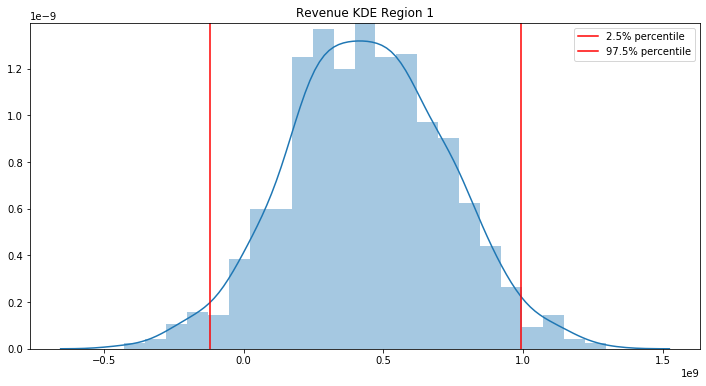

Среднее значение прибыли: 442.87 млн.руб.
С вероятностью 95% значение прибыли будет лежать в интервале от -121.79 до 992.23 млн.руб.
Шанс понести убытки равняется 5.80%



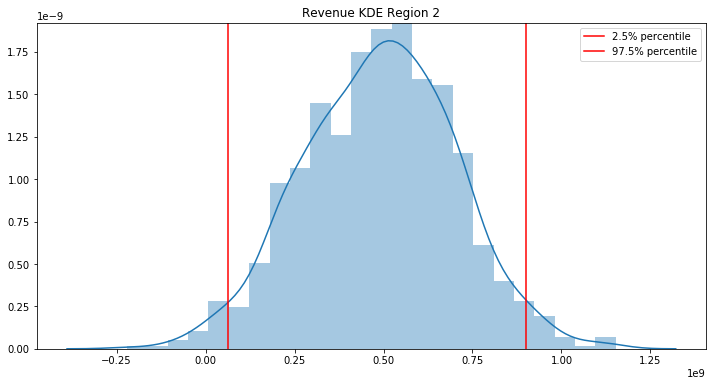

Среднее значение прибыли: 489.03 млн.руб.
С вероятностью 95% значение прибыли будет лежать в интервале от 63.88 до 900.13 млн.руб.
Шанс понести убытки равняется 1.00%



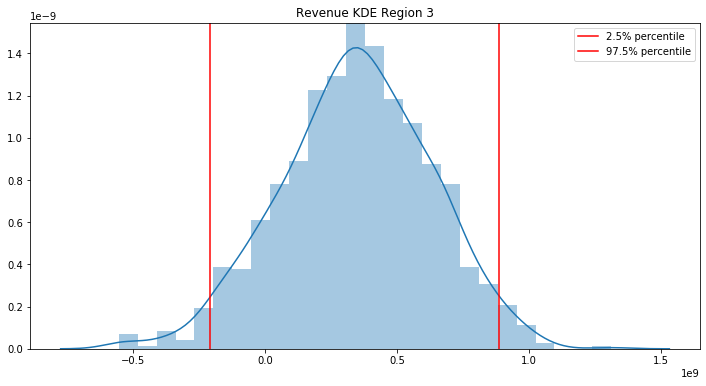

Среднее значение прибыли: 345.69 млн.руб.
С вероятностью 95% значение прибыли будет лежать в интервале от -207.67 до 884.78 млн.руб.
Шанс понести убытки равняется 11.60%



In [26]:
mean_revenue_0, conf_0, lesion_chanse_0 = bootstrep_revenue(results0['target'],
                                                            results0['predict'],
                                                            'Region 1')
mean_revenue_1, conf_1, lesion_chanse_1 = bootstrep_revenue(results1['target'],
                                                            results1['predict'], 
                                                            'Region 2')
mean_revenue_2, conf_2, lesion_chanse_2 = bootstrep_revenue(results2['target'],
                                                            results2['predict'],
                                                            "Region 3")

## Выводы по разделу.
Проведя исследования 3-х регионов, мы видим, что 3-й может быть сразу отброшен, так как он не соотвествует условию, что вероятность понести убыток должна быть меньше 2,4%.
Из оставшихся 2-х регионов для разработки следует выбрать регион из датасета geo_data_1(второй регион). По полученным значениям мы пришли к выводу, что:
- Из всех регионов выбранный нами имеет минимальный шанс понести убытки при бурении скважины;
- Данный регион обладает наибольшим средним значением прибыли;
- Наша модель может с высокой точностью предсказать объем запасов в скважине данного региона;
- 95% доверительный интервал не включает в себя отрицательные значения, что означает, что в 97,5% случаев бурение двухсот лучших скважин принесет нам гарантированную прибыль.

# Выводы по проекту.
Для оценки объема запасов нефти нами была псчитана простая модель линейной регрессии. Для региона 1 и 3 данная модель довольно точно предсказывала средний объем запасов, но очень сильно ошибалась на конкретных скважинах, корень из среднеквадратичной ошибки равнялся половине от среднего значения для данного региона.

Для региона 2 модель смогла близко определить закономерность, поэтому она точно предсказывает запасы нефти для каждой конкретной скважины.

Исходя из условий, поставленных перед нами, мы определили, что порог безубыточности скважины - 112 тыс. баррелей нефти.

Нами была написана функция, которая производит подсчет прибыли полученной от разработки региона. Для расчета прибыли берутся 200 наиболее перспективных скважин.

Для получения распределения прибыли мы воспользовались техникой бутстреп. Случайном образом были сформированы 1000 подвыборок с 500 случайными скважинами, для каждой подвыборки была подсчитана прибыль. 

Получив распределение прибыли мы смогли расчитать 95% доверительный интервал. Так как не каждая выборка гарантированно приносила прибыль мы высчитали и шанс несения убытков.

По результатам расчетов мы рекомендуем проводить разведку второго региона(geo_data1), по следующим причинам:
   - Из всех регионов выбранный нами имеет минимальный шанс понести убытки при бурении скважины;
   - Данный регион обладает наибольшим средним значением прибыли;
   - Наша модель может с высокой точностью предсказать объем запасов в скважине данного региона;
   - 95% доверительный интервал не включает в себя отрицательные значения, что означает, что в 97,5% случаев бурение двухсот лучших скважин принесет нам гарантированную прибыль.